In [1]:
%%time
#computing libraries
!pip3 install distributed
!pip3 install dask
!pip3 install py4j
!pip3 install findspark
!pip3 install dask
!pip3 install dask_yarn
!pip3 install ray
!pip3 install tensorboardX # for Ray lightGBM
#retreive packages and install
#numerapi for retreiving data of numerai
!pip install numerapi
!pip3 install numerapi
#pip is the mother of package retreival (pip and pip3)
!pip install --upgrade pip
#Tpot is the algo of algos
!pip3 install git+https://github.com/EpistasisLab/tpot@development
#xgboost is a very good algo
!pip install xgboost
!pip3 install xgboost --upgrade
#!pip install pystan
#!pip install fbprophet
!pip3 install ipywidgets
!pip3 install Sklearn_pandas
!pip3 install featuretools
!pip3 install keras-tuner
!pip3 install deepgraph
print("All installed")

  Cloning https://github.com/EpistasisLab/tpot (to revision development) to /tmp/pip-req-build-lc6_0i5b
  Running command git clone -q https://github.com/EpistasisLab/tpot /tmp/pip-req-build-lc6_0i5b
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
All installed
CPU times: user 2.37 s, sys: 515 ms, total: 2.88 s
Wall time: 1min 51s


![](https://numer.ai/img/Numerai-Logo-Side-Black.8393ed16.png)


- version 3: 
- version 4: 
- version 5: target nomi

(https://jp.docs.numer.ai/numerai-tournament/new-users)

# Libraries

In [2]:
%%time
# Parallel computing
import dask
import dask.dataframe as dd
import dask_yarn
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import os
import distributed
import py4j
import findspark
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
from multiprocessing import Pool
import deepgraph as dg

# Data science
import sklearn.datasets
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet, RANSACRegressor, HuberRegressor, PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
        
# engineer features
import featuretools as ft
from featuretools import selection

# General coding
import numerapi
import numpy as np
import pandas as pd
import sys
import datetime
import math
import random
import gc
import pathlib
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from scipy.stats import spearmanr
import joblib
import csv
import operator

# model
import lightgbm as lgb
import xgboost as xgb
from lightgbm import plot_importance
import sklearn.metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance
import tensorflow as tf 
import kerastuner as kt # keras tuner!

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

print("Import completed")
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Import completed
CPU times: user 3.55 s, sys: 353 ms, total: 3.9 s
Wall time: 3.9 s


In [3]:
"""
%%time
!pip3 install py4j
from py4j import *
# Record time
print("Current date and time: ",str(datetime.datetime.now()))

# Computing: initiate Spark
#findspark.init('/home/hadoopuser/spark-3.1.1-bin-hadoop3.2')
conf = (SparkConf()
       .set("spark.yarn.executor.memoryOverhead", "4096")
       .set("spark.kryoserializer.buffer.max.mb", "1024"))
sc = pyspark.SparkContext.getOrCreate(conf=conf)
from pyspark.sql import SQLContext
sqlcontext = SQLContext(sc)
#after first run uncomment the next line as the spark1 is permanent
#spark1= SparkSession.builder.appName('Ops').getOrCreate()
"""
# Initialize other
sns.set_context("talk")
style.use('seaborn-colorblind')
NAPI = numerapi.NumerAPI(verbosity="info")

# Config
Here you can choose what you do: 

- Debug mode (using small proportion of data)?
- Tuning or not?
- Which target to predict?
- Seed number?

In [4]:
class CFG:
    DEBUG = True # debug option
    TUNING = True # whether to use the KerasTuner or not
    LOAD = True
    DIR = ''
    #INPUT_FILE_PATH = '../input/numerai-train-validation-with-kazutsugi-nomi/numerai_training_validation_target_nomi.csv'
    OUTPUT_DIR = ''
    TARGET = 'target' 
    SEED = 2021

In [5]:
# Logging is always nice for your experiment:)
def init_logger(log_file=CFG.OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = init_logger()
logger.info('Start Logging...')

Start Logging...
2021-05-30 00:47:26,324 INFO __main__: Start Logging...


In [6]:
logger.info('DEBUG : {}'.format(CFG.DEBUG))
logger.info('TUNING : {}'.format(CFG.TUNING))
logger.info('TARGET : {}'.format(CFG.TARGET))

DEBUG : True
2021-05-30 00:47:26,352 INFO __main__: DEBUG : True
TUNING : True
2021-05-30 00:47:26,354 INFO __main__: TUNING : True
TARGET : target
2021-05-30 00:47:26,355 INFO __main__: TARGET : target


# Tournament 
Get the data necessary


In [7]:
%%time
#straight download if directory <1 gb takes 7minutes and 8 seconds the first time < 1 second second time
# source: https://memotut.com/en/366a2d1c273507dd4b8c/
DIR = "numer"
def download_current_data(directory: str):
        """
        Downloads the data for the current round
        :param directory: The path to the directory where the data needs to be saved
        """
        current_round = NAPI.get_current_round()
        if os.path.isdir(f'{directory}/numerai_dataset_{current_round}/'):
            print(f"You already have the newest data! Current round is: {current_round}")
        else:
            print(f"Downloading new data for round: {current_round}!")
            NAPI.download_current_dataset(dest_path=directory, unzip=True)
            
def get_int(x):
    try:
        return int(x[3:])
    except:
        return 1000

# Called 2x
def read_data(data='train'):
    # get data 
    if data == 'train':
        df = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz')
    elif data == 'test':
        df = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz')
    
    # features
    feature_cols = df.columns[df.columns.str.startswith('feature')]
    
    # map to int, to reduce the memory demand
    mapping = {0.0 : 0, 0.25 : 1, 0.5 : 2, 0.75 : 3, 1.0 : 4}
    for c in feature_cols:
        df[c] = df[c].map(mapping).astype(np.uint8)
        
    # also cast era to int
    df["era"] = df["era"].apply(get_int)
    return df

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.54 µs


In [8]:
%%time
print("Current date and time: ",str(datetime.datetime.now()))
# Load data to variables
train = read_data('train')
test = read_data('test')
print(train.shape)
print(test.shape)
print(len(test))
print("Current date and time: ",str(datetime.datetime.now()))
# till here it usually takes 10 minutes and 12gb of memory, memory peak at 15gb

Current date and time:  2021-05-30 00:47:26.421321
(501808, 314)
(1731016, 314)
1731016
Current date and time:  2021-05-30 00:57:37.815192
CPU times: user 3min 59s, sys: 3min 50s, total: 7min 49s
Wall time: 10min 11s


<h4> Measure memory usage </h4>

In [9]:
%%time
print("Current date and time: ",str(datetime.datetime.now()))
#memory usages
train.info(memory_usage='deep')
test.info(memory_usage='deep')
print(test.head())

Current date and time:  2021-05-30 00:57:37.827440
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float64(1), int64(1), object(2), uint8(310)
memory usage: 220.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731016 entries, 0 to 1731015
Columns: 314 entries, id to target
dtypes: float64(1), int64(1), object(2), uint8(310)
memory usage: 760.2 MB
                 id  era   data_type  feature_intelligence1  \
0  n0003aa52cab36c2  121  validation                      1   
1  n000920ed083903f  121  validation                      3   
2  n0038e640522c4a6  121  validation                      4   
3  n004ac94a87dc54b  121  validation                      3   
4  n0052fe97ea0c05f  121  validation                      1   

   feature_intelligence2  feature_intelligence3  feature_intelligence4  \
0                      3                      2                      2   
1                      2                    

In [10]:
#create validation dataset from test and validation data
val = test[test["data_type"] == "validation"].reset_index(drop = True)
print(val.shape)

(137779, 314)


In [11]:
#DROPS
# remove data_type to save memory
train.drop(columns=["data_type"], inplace=True)
val.drop(columns=["data_type"], inplace=True)
test.drop(columns=["data_type"], inplace=True)

In [12]:
# TODO store data to CSV files on Google Drive for rerun of model from EDA and on Kaggle/Colab/Server
napi = numerapi.NumerAPI(verbosity="info")
# download current dataset
napi.download_current_dataset(unzip=True)
current_ds = napi.get_current_round()
print('Current round: ',current_ds)
latest_round = os.path.join('numerai_dataset_'+str(current_ds))

#first investigation stats, how many columns and rows do we got
print('The number of records: train {:,}, valid {:,}, test {:,}'.format(train.shape[0], val.shape[0], test.shape[0]))

./numerai_dataset_266.zip: 100%|█████████▉| 406M/406M [04:19<00:00, 1.52MB/s]   2021-05-30 01:02:00,874 INFO numerapi.base_api: unzipping file...
./numerai_dataset_266.zip: 406MB [04:30, 1.52MB/s]                           

Current round:  266
The number of records: train 501,808, valid 137,779, test 1,731,016


# EDA (Exploratory Data Analysis) & Feature engineering


In [13]:
#11.5gb memory in use
# features
feature_cols = train.columns[train.columns.str.startswith('feature')]
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))


There are 310 features.


310

- intelligence (1 ~ 12)
- charisma (1 ~ 86)
- strength (1 ~ 38)
- dexterity (1 ~ 14)
- constitution (1 ~ 114)
- wisdom (1 ~ 46)



In [14]:
%%time
val_spark = spark.createDataFrame(val)
print(val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137779 entries, 0 to 137778
Columns: 313 entries, id to target
dtypes: float64(1), int64(1), object(1), uint8(310)
memory usage: 43.9+ MB
None
CPU times: user 5min 37s, sys: 1.04 s, total: 5min 38s
Wall time: 5min 40s


## Feature engineering

In [15]:
#TODO add the log and higher orders
# TODO multithreading
def get_group_stats(df: pd.DataFrame) -> pd.DataFrame:
        """
        Create features by calculating statistical moments for each group.

        :param df: Pandas DataFrame containing all features
        """
        for group in ["1","0","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
            cols = [col for col in df.columns if group in col]
            df[f"feature_{group}_mean"] = df[cols].mean(axis=1)
            df[f"feature_{group}_median"] = df[cols].median(axis=1)
            #df[f"feature_{group}_mad"] = df[cols].mad(axis=1)
            #df[f"feature_{group}_product"] = df[cols].product(axis=1)
            df[f"feature_{group}_std"] = df[cols].std(axis=1)
            #df[f"feature_{group}_var"] = df[cols].var(axis=1)          
            df[f"feature_{group}_skew"] = df[cols].skew(axis=1)
            df[f"feature_{group}_sum"] = df[cols].sum(axis=1)
            df[f"feature_{group}_kurt"] = df[cols].kurt(axis=1)
            #df[f"feature_{group}_min"] = df[cols].min(axis=1) 
            #df[f"feature_{group}_max"] = df[cols].max(axis=1)
          
        return df



In [16]:
%%time
#store complete frames
train_orig = train
test_orig = test
val_orig = val
# proram to Dask or Ray
print("Current date and time: ",str(datetime.datetime.now()))
# Add group statistics features
train = get_group_stats(train)
print(train.head())
test = get_group_stats(test)
print(test.head())
val = get_group_stats(val)
print(val.head())
# Feature engineering with featuretools 
# theory https://medium.com/dataexplorations/tool-review-can-featuretools-simplify-the-process-of-feature-engineering-5d165100b0c3
# example https://www.programmersought.com/article/68271856160/

Current date and time:  2021-05-30 01:07:56.257561
                 id  era  feature_intelligence1  feature_intelligence2  \
0  n000315175b67977    1                      0                      2   
1  n0014af834a96cdd    1                      0                      0   
2  n001c93979ac41d4    1                      1                      2   
3  n0034e4143f22a13    1                      4                      0   
4  n00679d1a636062f    1                      1                      1   

   feature_intelligence3  feature_intelligence4  feature_intelligence5  \
0                      1                      0                      2   
1                      0                      1                      2   
2                      1                      1                      4   
3                      0                      2                      2   
4                      1                      1                      0   

   feature_intelligence6  feature_intelligence7  feature_in

In [17]:
#TODO make complete frames
print(train[f'target'].head())
#Takes 15 minutes to finish this part on Xeon 110gb ddr3, 2x e5-2693v2
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))

0    0.50
1    0.25
2    0.25
3    0.25
4    0.75
Name: target, dtype: float64
There are 454 features.


In [18]:
"""
%%time
print("Current date and time: ",str(datetime.datetime.now()))
X_train = train[features].to_numpy()
y_train = train[f'target']

#selection 1
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X_train.shape[1])

# Create the model with several hyperparameters
modellgb = lgb.LGBMRegressor(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X_train, y_train, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    modellgb.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += modellgb.feature_importances_
    
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importances}).sort_values('importance', ascending = False)
"""

'\n%%time\nprint("Current date and time: ",str(datetime.datetime.now()))\nX_train = train[features].to_numpy()\ny_train = train[f\'target\']\n\n#selection 1\n# Initialize an empty array to hold feature importances\nfeature_importances = np.zeros(X_train.shape[1])\n\n# Create the model with several hyperparameters\nmodellgb = lgb.LGBMRegressor(objective=\'binary\', boosting_type = \'goss\', n_estimators = 10000, class_weight = \'balanced\')\n\n# Fit the model twice to avoid overfitting\nfor i in range(2):\n    \n    # Split into training and validation set\n    train_features, valid_features, train_y, valid_y = train_test_split(X_train, y_train, test_size = 0.25, random_state = i)\n    \n    # Train using early stopping\n    modellgb.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], \n              eval_metric = \'auc\', verbose = 200)\n    \n    # Record the feature importances\n    feature_importances += modellgb.feature_importances_\n    

In [19]:
"""
# LGB feature importances
print('There are {} features.'.format(len(features)))
print('LGB feature importances:')
print(feature_importances.feature[0:50])
#Select importance
lgbimp = 4.00 #adjust text
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] <= lgbimp]['feature'])
print('There are %d features with lower than 4.00 importance' % len(zero_features))
feature_importances.tail()
"""

"\n# LGB feature importances\nprint('There are {} features.'.format(len(features)))\nprint('LGB feature importances:')\nprint(feature_importances.feature[0:50])\n#Select importance\nlgbimp = 4.00 #adjust text\n# Find the features with zero importance\nzero_features = list(feature_importances[feature_importances['importance'] <= lgbimp]['feature'])\nprint('There are %d features with lower than 4.00 importance' % len(zero_features))\nfeature_importances.tail()\n"

In [20]:
#DROPS
#train = train.drop(columns = zero_features)
#test = test.drop(columns = zero_features)
#val = val.drop(columns = zero_features)
print('LGB model:')
print('Training selection 1 shape: ', train.shape)
print('Testing selection 1 shape: ', test.shape)
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))

LGB model:
Training selection 1 shape:  (501808, 457)
Testing selection 1 shape:  (1731016, 457)
There are 454 features.


In [21]:
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))

There are 454 features.


In [22]:
#DROPS
#Turn off to raise the amont of features skipping XGB of the first step """"""
#keep <10% of features per model
#train = train.drop(columns = zero_features2)
#test = test.drop(columns = zero_features2)
#val = val.drop(columns = zero_features2)
print('XGB model:')
print('Training selection 2 shape: ', train.shape)
print('Testing selection 2 shape: ', test.shape)

XGB model:
Training selection 2 shape:  (501808, 457)
Testing selection 2 shape:  (1731016, 457)


In [23]:
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))
#https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

There are 454 features.


In [24]:
# plot feature importance LGB
#norm_feature_importances = plot_feature_importances(feature_importances)
# plot feature importance XGB
#norm_feature_importances = plot_feature_importances(feature_importances2)

In [25]:
# about 12 gb in ram memory
print("Current date and time: ",str(datetime.datetime.now()))
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))

Current date and time:  2021-05-30 01:13:17.695920
There are 454 features.


In [26]:
%%time
#TODO speed up compute with multithreading/gpu
#train_spark = spark.createDataFrame(train)
#print(train_spark.info())

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


In [27]:
!pip3 install tbb
!pip3 install numba
import threading
import pandas as pd
from numba import config, njit, threading_layer, jit
import numpy as np
# set the threading layer before any parallel target compilation
config.THREADING_LAYER = 'threadsafe'

# Derive derivative features
def get_calc_stats(df: pd.DataFrame) -> pd.DataFrame:
        """
        Create features by calculating statistical moments for each group.

        :param df: Pandas DataFrame containing all features
        """
        for feature in features:
            cols = [col for col in df.columns if feature == col]
            df[f"{feature}_sqrt"] = df[cols].apply(np.sqrt) #sqrt
            df[f"{feature}_log"] = np.log(df[cols]+1) #log   
            df[f"{feature}_exp2"] = df[cols].apply(lambda x: x**2)  #quadratic  
            df[f"{feature}_exp3"] = df[cols].apply(lambda x: x**3)  #cube   
        return df

In [28]:
%%time
## TODO fix threading
import datetime
### TODO Spark numba GPU speed up by using multiple jobs using processors
print("Current date and time: ",str(datetime.datetime.now()))

get_calc_stats_jit = jit()(get_calc_stats)

# Add group statistics features
train = target=get_calc_stats_jit(train)

val = target=get_calc_stats(val)

test = get_calc_stats(test)

# demonstrate the threading layer chosen
print("Threading layer chosen: %s" % threading_layer())
print(train.head())
print(val.head())
print(test.head())
print("Current date and time: ",str(datetime.datetime.now()))
#peaks at 43 gb in use and takes 90 minutes then gives back data
#2270 features
#1:30min on the 320gb 2x xeon e5-2695v2 without gpu

Current date and time:  2021-05-30 01:13:23.856570


UnsupportedError: Failed in object mode pipeline (step: analyzing bytecode)
[1mUse of unsupported opcode (FORMAT_VALUE) found
[1m
File "<ipython-input-27-5fc3ae1dab81>", line 19:[0m
[1mdef get_calc_stats(df: pd.DataFrame) -> pd.DataFrame:
    <source elided>
            cols = [col for col in df.columns if feature == col]
[1m            df[f"{feature}_sqrt"] = df[cols].apply(np.sqrt) #sqrt
[0m            [1m^[0m[0m
[0m

In [29]:
#TODO add TSFresh features



In [30]:
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))
print(features)

There are 454 features.
['feature_intelligence1', 'feature_intelligence2', 'feature_intelligence3', 'feature_intelligence4', 'feature_intelligence5', 'feature_intelligence6', 'feature_intelligence7', 'feature_intelligence8', 'feature_intelligence9', 'feature_intelligence10', 'feature_intelligence11', 'feature_intelligence12', 'feature_charisma1', 'feature_charisma2', 'feature_charisma3', 'feature_charisma4', 'feature_charisma5', 'feature_charisma6', 'feature_charisma7', 'feature_charisma8', 'feature_charisma9', 'feature_charisma10', 'feature_charisma11', 'feature_charisma12', 'feature_charisma13', 'feature_charisma14', 'feature_charisma15', 'feature_charisma16', 'feature_charisma17', 'feature_charisma18', 'feature_charisma19', 'feature_charisma20', 'feature_charisma21', 'feature_charisma22', 'feature_charisma23', 'feature_charisma24', 'feature_charisma25', 'feature_charisma26', 'feature_charisma27', 'feature_charisma28', 'feature_charisma29', 'feature_charisma30', 'feature_charisma31',

## Feature selection of derivatives
Keep on calibrating till you have about 100 final features

In [31]:
"""
%%time
print("Current date and time: ",str(datetime.datetime.now()))  
Xgroup_train = train[features].to_numpy()
ygroup_train = train[f'target']
#selection 3
# Initialize an empty array to hold feature importances
feature_importances3 = np.zeros(Xgroup_train.shape[1])

# Create the model with several hyperparameters
modellgbgroup = lgb.LGBMRegressor(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    grouptrain_features, groupvalid_features, train_ygroup, valid_ygroup = train_test_split(Xgroup_train, ygroup_train, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    modellgbgroup.fit(grouptrain_features, train_ygroup, early_stopping_rounds=100, eval_set = [(groupvalid_features, valid_ygroup)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances3 += modellgbgroup.feature_importances_
    
# Make sure to average feature importances! 
feature_importances3 = feature_importances3 / 2
feature_importances3 = pd.DataFrame({'feature': list(features), 'importance': feature_importances3}).sort_values('importance', ascending = False)
"""

'\n%%time\nprint("Current date and time: ",str(datetime.datetime.now()))  \nXgroup_train = train[features].to_numpy()\nygroup_train = train[f\'target\']\n#selection 3\n# Initialize an empty array to hold feature importances\nfeature_importances3 = np.zeros(Xgroup_train.shape[1])\n\n# Create the model with several hyperparameters\nmodellgbgroup = lgb.LGBMRegressor(objective=\'binary\', boosting_type = \'goss\', n_estimators = 10000, class_weight = \'balanced\')\n\n# Fit the model twice to avoid overfitting\nfor i in range(2):\n    \n    # Split into training and validation set\n    grouptrain_features, groupvalid_features, train_ygroup, valid_ygroup = train_test_split(Xgroup_train, ygroup_train, test_size = 0.25, random_state = i)\n    \n    # Train using early stopping\n    modellgbgroup.fit(grouptrain_features, train_ygroup, early_stopping_rounds=100, eval_set = [(groupvalid_features, valid_ygroup)], \n              eval_metric = \'auc\', verbose = 200)\n    \n    # Record the feature

In [32]:
"""
print('There are {} features.'.format(len(features)))
# LGB group feature importances 3
print('LGB group feature importances:')
print(feature_importances3.feature[0:9])
#Select importance
lgbgimp = 6.00 #adjust text
# Find the features with zero importance
zero_features3 = list(feature_importances3[feature_importances3['importance'] <= lgbgimp]['feature'])
print('There are %d features with lower than 6.00 importance' % len(zero_features3))
feature_importances3.tail()
"""

"\nprint('There are {} features.'.format(len(features)))\n# LGB group feature importances 3\nprint('LGB group feature importances:')\nprint(feature_importances3.feature[0:9])\n#Select importance\nlgbgimp = 6.00 #adjust text\n# Find the features with zero importance\nzero_features3 = list(feature_importances3[feature_importances3['importance'] <= lgbgimp]['feature'])\nprint('There are %d features with lower than 6.00 importance' % len(zero_features3))\nfeature_importances3.tail()\n"

In [33]:
#DROPS
#train = train.drop(columns = zero_features3)
#test = test.drop(columns = zero_features3)
#val = val.drop(columns = zero_features3)
print('LGBM model:')
print('Training selection 3 shape: ', train.shape)
print('Testing selection 3 shape: ', test.shape)
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))
print(features)

LGBM model:
Training selection 3 shape:  (501808, 457)
Testing selection 3 shape:  (1731016, 457)
There are 454 features.
['feature_intelligence1', 'feature_intelligence2', 'feature_intelligence3', 'feature_intelligence4', 'feature_intelligence5', 'feature_intelligence6', 'feature_intelligence7', 'feature_intelligence8', 'feature_intelligence9', 'feature_intelligence10', 'feature_intelligence11', 'feature_intelligence12', 'feature_charisma1', 'feature_charisma2', 'feature_charisma3', 'feature_charisma4', 'feature_charisma5', 'feature_charisma6', 'feature_charisma7', 'feature_charisma8', 'feature_charisma9', 'feature_charisma10', 'feature_charisma11', 'feature_charisma12', 'feature_charisma13', 'feature_charisma14', 'feature_charisma15', 'feature_charisma16', 'feature_charisma17', 'feature_charisma18', 'feature_charisma19', 'feature_charisma20', 'feature_charisma21', 'feature_charisma22', 'feature_charisma23', 'feature_charisma24', 'feature_charisma25', 'feature_charisma26', 'feature_ch

In [36]:
#DROPS
#Drop useless variables
#train = train.drop(columns = zero_features4)
#test = test.drop(columns = zero_features4)
#val = val.drop(columns = zero_features4)
print('XGB model:')
print('Training selection 4 shape: ', train.shape)
print('Testing selection 4 shape: ', test.shape)

XGB model:
Training selection 4 shape:  (501808, 457)
Testing selection 4 shape:  (1731016, 457)


In [37]:
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))

There are 454 features.


In [40]:
%%time
#60gb occupied, reduce to 10
print("Current date and time: ",str(datetime.datetime.now())) 
Xcalc_train = train[features].to_numpy()
ycalc_train = train[f'target']

#selection 5
# Initialize an empty array to hold feature importances
feature_importances5 = np.zeros(Xcalc_train.shape[1])

# Create the model with several hyperparameters
modellgbcalc = lgb.LGBMRegressor(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    calctrain_features, calcvalid_features, train_ycalc, valid_ycalc = train_test_split(Xcalc_train, ycalc_train, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    modellgbcalc.fit(calctrain_features, train_ycalc, early_stopping_rounds=100, eval_set = [(calcvalid_features, valid_ycalc)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances5 += modellgbcalc.feature_importances_
    
# Make sure to average feature importances! 
feature_importances5 = feature_importances5 / 2
feature_importances5 = pd.DataFrame({'feature': list(features), 'importance': feature_importances5}).sort_values('importance', ascending = False
)
#AUC 0.72

Current date and time:  2021-05-30 01:13:24.767317
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.728955	valid_0's binary_logloss: 0.25188
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.725184	valid_0's binary_logloss: 0.253429
CPU times: user 3min 35s, sys: 2.08 s, total: 3min 37s
Wall time: 3min 37s


In [41]:
# LGB group feature importances 5
print('LGB group feature importances:')
print(feature_importances5.feature[0:19])
#Select importance
lgbcimp = 5 #adjust text
# Find the features with zero importance
zero_features5 = list(feature_importances5[feature_importances5['importance'] <= lgbcimp]['feature'])
print('There are %d features with lower than 5.00 importance' % len(zero_features5))
feature_importances5.tail()


LGB group feature importances:
0       feature_intelligence1
3       feature_intelligence4
7       feature_intelligence8
372            feature_10_std
433     feature_charisma_skew
441    feature_dexterity_kurt
424       feature_wisdom_mean
300          feature_wisdom37
432      feature_charisma_std
330             feature_3_std
203    feature_constitution54
438     feature_dexterity_std
47         feature_charisma36
361            feature_8_skew
375           feature_10_kurt
285          feature_wisdom22
427       feature_wisdom_skew
298          feature_wisdom35
360             feature_8_std
Name: feature, dtype: object
There are 306 features with lower than 5.00 importance


,feature,importance
404,feature_15_sum,0.0
317,feature_0_median,0.0
314,feature_1_sum,0.0
410,feature_16_sum,0.0
344,feature_5_sum,0.0


In [42]:
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print(features)
print(len(features))

['feature_intelligence1', 'feature_intelligence2', 'feature_intelligence3', 'feature_intelligence4', 'feature_intelligence5', 'feature_intelligence6', 'feature_intelligence7', 'feature_intelligence8', 'feature_intelligence9', 'feature_intelligence10', 'feature_intelligence11', 'feature_intelligence12', 'feature_charisma1', 'feature_charisma2', 'feature_charisma3', 'feature_charisma4', 'feature_charisma5', 'feature_charisma6', 'feature_charisma7', 'feature_charisma8', 'feature_charisma9', 'feature_charisma10', 'feature_charisma11', 'feature_charisma12', 'feature_charisma13', 'feature_charisma14', 'feature_charisma15', 'feature_charisma16', 'feature_charisma17', 'feature_charisma18', 'feature_charisma19', 'feature_charisma20', 'feature_charisma21', 'feature_charisma22', 'feature_charisma23', 'feature_charisma24', 'feature_charisma25', 'feature_charisma26', 'feature_charisma27', 'feature_charisma28', 'feature_charisma29', 'feature_charisma30', 'feature_charisma31', 'feature_charisma32', '

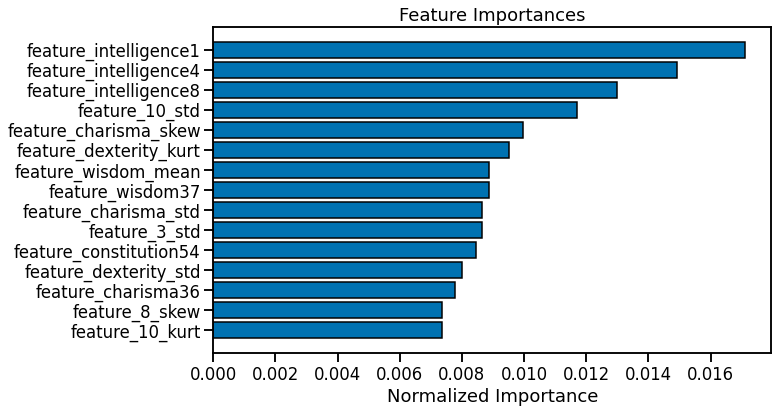

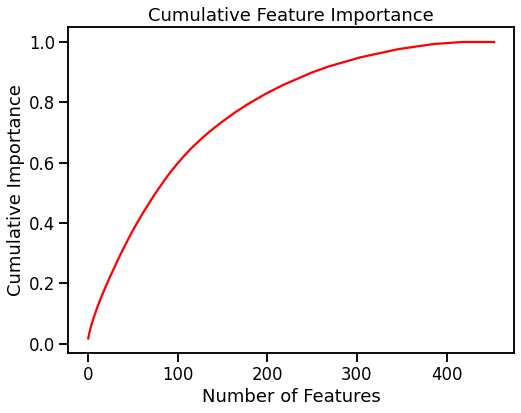

252 features required for 0.90 of cumulative importance


In [43]:
# plot feature importance XGB group 5
norm_feature_importances = plot_feature_importances(feature_importances5)

In [44]:
#DROPS
# Skip to keep the groups and derived variables with lower than 2
train = train.drop(columns = zero_features5)
test = test.drop(columns = zero_features5)
val = val.drop(columns = zero_features5)
print('LGBM model:')
print('Training selection 5 shape: ', train.shape)
print('Testing selection 5 shape: ', test.shape)
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))

LGBM model:
Training selection 5 shape:  (501808, 151)
Testing selection 5 shape:  (1731016, 151)
There are 148 features.


In [45]:
# backup data
train.to_csv('train2.csv')
test.to_csv('test2.csv')
val.to_csv('val2.csv')

## Feature Selection with feature selection tools on Interaction variables 
Featuretools: subtract_numeric, a*b, b*c, a*c, haversine

In [46]:
%%time

print("Current date and time: ",str(datetime.datetime.now()))
#now we want to have transformations
es = ft.EntitySet(id = 'id')
# Create an entity from the client dataframe
# This dataframe already has an index and a time index
tr_sub1 = es.entity_from_dataframe(entity_id = 'tr', dataframe = train, 
                               index = 'id', time_index = 'era')
te_sub1 = es.entity_from_dataframe(entity_id = 'te', dataframe = test, 
                               index = 'id', time_index = 'era')
va_sub1 = es.entity_from_dataframe(entity_id = 'va', dataframe = val, 
                               index = 'id', time_index = 'era')


Current date and time:  2021-05-30 01:22:03.688076
CPU times: user 9.46 s, sys: 1.47 s, total: 10.9 s
Wall time: 10.9 s


In [47]:
%%time
# takes 60-80 minutes for 40 features
print("Current date and time: ",str(datetime.datetime.now()))
#Timed:
agg_primitives = ['std','mean','mode']
featurestr, feature_names = ft.dfs(entityset = tr_sub1, target_entity = 'tr',
                                 max_depth = 2, max_features = 700,
                                 n_jobs = 24,
                                 chunk_size = 200,                                 
                                 agg_primitives = agg_primitives,#agg_primitives = ['mode','sum'],#,'mean','median','max','count','min','percent_true', 'last','skew'
                                 trans_primitives = ['subtract_numeric','haversine'],
                                 verbose = True)#'subtract_numeric', ,'equal','diff',
print("train feature creation done")
featureste, feature_names = ft.dfs(entityset = te_sub1, target_entity = 'te',
                                 max_depth = 2, max_features = 700,
                                 n_jobs = 24,
                                 chunk_size = 200,                                 
                                 agg_primitives = agg_primitives,#['mode','sum'],#,'mean','median','max','count','min','percent_true', 'last','skew'
                                 trans_primitives = ['subtract_numeric','haversine'],
                                 verbose = True)#'subtract_numeric', ,'equal','diff',
print("test feature creation done")
featuresva, feature_namesva = ft.dfs(entityset = va_sub1, target_entity = 'va',
                                 max_depth = 2, max_features = 700,
                                 n_jobs = 24,
                                 chunk_size = 200,                                 
                                 agg_primitives = agg_primitives,#agg_primitives = ['mode','sum'],#,'mean','median','max','count','min','percent_true', 'last','skew'
                                 trans_primitives = ['subtract_numeric','haversine'],
                                 verbose = True)#'subtract_numeric', ,'equal','diff',
print("validation feature creation done")
#https://medium.com/analytics-vidhya/feature-engineering-using-featuretools-with-code-10f8c83e5f68
print(feature_names)


Current date and time:  2021-05-30 01:22:14.606233
Built 700 features


/home/hadoopuser/.local/lib/python3.8/site-packages/featuretools/synthesis/dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['haversine']
  agg_primitives: ['mean', 'mode', 'std']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)



Elapsed: 00:00 | Progress:   0%|          
Elapsed: 00:00 | Progress:   0%|          

./numerai_dataset_266.zip: 406MB [28:45, 1.52MB/s]

EntitySet scattered to 24 workers in 68 seconds

Elapsed: 00:00 | Progress:   0%|          
Elapsed: 00:04 | Progress:   0%|          
Elapsed: 00:04 | Progress:   0%|          
Elapsed: 00:04 | Progress:   0%|          
Elapsed: 00:05 | Progress:   1%|          
Elapsed: 00:05 | Progress:   1%|          
Elapsed: 00:06 | Progress:   1%|          
Elapsed: 00:06 | Progress:   2%|▏         
Elapsed: 00:07 | Progress:   2%|▏         
Elapsed: 00:07 | Progress:   3%|▎         
Elapsed: 00:07 | Progress:   3%|▎         
Elapsed: 00:08 | Progress:   3%|▎         
Elapsed: 00:08 | Progress:   4%|▍         
Elapsed: 00:09 | Progress:   4%|▍         
Elapsed: 00:09 | Progress:   4%|▍         
Elapsed: 00:09 | Progress:   5%|▍         
Elapsed: 00:09 | Progress:   5%|▌         
Elapsed: 00:10 | Progress:   5%|▌         
Elapsed: 00:10 | Progress:   6%|▌         
Elapsed: 00:11 | Progress:   6%|▌         
Elapsed: 00:11 | Progress:   6%|▌         
Elapsed: 00:11 | Progress:   7%|▋         
Elaps

/home/hadoopuser/.local/lib/python3.8/site-packages/featuretools/synthesis/dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['haversine']
  agg_primitives: ['mean', 'mode', 'std']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)



Elapsed: 00:00 | Progress:   0%|          
Elapsed: 00:00 | Progress:   0%|          

./numerai_dataset_266.zip: 406MB [35:11, 1.52MB/s]

EntitySet scattered to 24 workers in 64 seconds

Elapsed: 00:00 | Progress:   0%|          
Elapsed: 00:12 | Progress:   0%|          
Elapsed: 00:12 | Progress:   0%|          
Elapsed: 00:12 | Progress:   0%|          
Elapsed: 00:13 | Progress:   0%|          
Elapsed: 00:13 | Progress:   0%|          
Elapsed: 00:13 | Progress:   0%|          
Elapsed: 00:14 | Progress:   0%|          
Elapsed: 00:14 | Progress:   1%|          
Elapsed: 00:15 | Progress:   1%|          
Elapsed: 00:15 | Progress:   1%|          
Elapsed: 00:15 | Progress:   1%|          
Elapsed: 00:15 | Progress:   1%|          
Elapsed: 00:16 | Progress:   1%|          
Elapsed: 00:16 | Progress:   1%|          
Elapsed: 00:17 | Progress:   1%|          
Elapsed: 00:17 | Progress:   1%|▏         
Elapsed: 00:18 | Progress:   1%|▏         
Elapsed: 00:18 | Progress:   2%|▏         
Elapsed: 00:18 | Progress:   2%|▏         
Elapsed: 00:19 | Progress:   2%|▏         
Elapsed: 00:19 | Progress:   2%|▏         
Elaps

/home/hadoopuser/.local/lib/python3.8/site-packages/featuretools/synthesis/dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['haversine']
  agg_primitives: ['mean', 'mode', 'std']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)



Elapsed: 00:00 | Progress:   0%|          

./numerai_dataset_266.zip: 406MB [47:23, 1.52MB/s]

EntitySet scattered to 24 workers in 68 seconds

Elapsed: 00:00 | Progress:   0%|          
Elapsed: 00:02 | Progress:   0%|          
Elapsed: 00:02 | Progress:   0%|          
Elapsed: 00:03 | Progress:   1%|          
Elapsed: 00:03 | Progress:   3%|▎         
Elapsed: 00:03 | Progress:   4%|▍         
Elapsed: 00:04 | Progress:   5%|▍         
Elapsed: 00:04 | Progress:   7%|▋         
Elapsed: 00:05 | Progress:   8%|▊         
Elapsed: 00:05 | Progress:  10%|▉         
Elapsed: 00:05 | Progress:  11%|█         
Elapsed: 00:06 | Progress:  13%|█▎        
Elapsed: 00:06 | Progress:  14%|█▍        
Elapsed: 00:07 | Progress:  15%|█▍        
Elapsed: 00:07 | Progress:  16%|█▋        
Elapsed: 00:07 | Progress:  18%|█▊        
Elapsed: 00:08 | Progress:  19%|█▉        
Elapsed: 00:08 | Progress:  21%|██        
Elapsed: 00:08 | Progress:  22%|██▏       
Elapsed: 00:09 | Progress:  23%|██▎       
Elapsed: 00:09 | Progress:  24%|██▍       
Elapsed: 00:09 | Progress:  25%|██▌       
Elaps

In [58]:
print(len(featurestr))

501808


In [49]:

# Remove features with only one unique value
featurestr = selection.remove_low_information_features(featurestr)
print('Removed %d features' % (featurestr.shape[1]- featurestr.shape[1]))
print("Current date and time: ",str(datetime.datetime.now()))
# Remove features with only one unique value
featureste = selection.remove_low_information_features(featureste)
print('Removed %d features' % (featureste.shape[1]- featureste.shape[1]))
print("Current date and time: ",str(datetime.datetime.now()))
# Remove features with only one unique value
featuresva = selection.remove_low_information_features(featuresva)
print('Removed %d features' % (featuresva.shape[1]- featuresva.shape[1]))
print("Current date and time: ",str(datetime.datetime.now()))


Removed 0 features
Current date and time:  2021-05-30 01:46:07.028415
Removed 0 features
Current date and time:  2021-05-30 01:47:32.353397
Removed 0 features
Current date and time:  2021-05-30 01:47:36.242474


In [50]:
# Switch to use feature selection
#trained = featurestr
#tested = featureste
#valed = featuresva
trained = train
tested = test
valed = val

# Train remove era and target interaction features
trained = trained[trained.columns.drop(list(trained.filter(regex='- target')))]
trained = trained[trained.columns.drop(list(trained.filter(regex='era -')))]
# Test remove era and target interaction features
tested = tested[tested.columns.drop(list(tested.filter(regex='- target')))]
tested = tested[tested.columns.drop(list(tested.filter(regex='era -')))]
# Val remove era and target interaction features
valed = valed[valed.columns.drop(list(valed.filter(regex='- target')))]
valed= valed[valed.columns.drop(list(valed.filter(regex='era -')))]

In [51]:
%%time
featured = [f for f in trained.columns.values.tolist() if 'feature' in f]
print(len(featured))
print("Current date and time: ",str(datetime.datetime.now())) 
Xcalc_trained = trained[featured].to_numpy()
ycalc_trained = trained[f'target']

#selection 7
# Initialize an empty array to hold feature importances
feature_importances7 = np.zeros(Xcalc_trained.shape[1])

# Create the model with several hyperparameters
modellgbcalc = lgb.LGBMRegressor(objective='binary', boosting_type = 'goss', n_estimators = 20000, class_weight = 'balanced')

# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    calctrained_featured, calcvaled_featured, trained_ycalc, valed_ycalc = train_test_split(Xcalc_trained, ycalc_trained, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    modellgbcalc.fit(calctrained_featured, trained_ycalc, early_stopping_rounds=100, eval_set = [(calcvaled_featured, valed_ycalc)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances7 += modellgbcalc.feature_importances_
    
# Make sure to average feature importances! 
feature_importances7 = feature_importances7 / 2
feature_importances7 = pd.DataFrame({'feature': list(featured), 'importance': feature_importances7}).sort_values('importance', ascending = False)


148
Current date and time:  2021-05-30 01:47:39.151631
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.728754	valid_0's binary_logloss: 0.253766
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.72581	valid_0's binary_logloss: 0.255324
CPU times: user 1min 20s, sys: 1.14 s, total: 1min 21s
Wall time: 1min 20s


In [52]:
featured = [f for f in trained.columns.values.tolist() if 'feature' in f]
print(len(featured))
# LGB group feature importances 7
print('LGB group feature importances:')
print(feature_importances7.feature[0:19])
#Select importance
lgbcin = 0.5 #adjust text
# Find the features with zero importance
zero_features7 = list(feature_importances7[feature_importances7['importance'] <= lgbcin]['feature'])
print('There are %d features with lower than 0.50 importance' % len(zero_features7))
feature_importances7.tail()

148
LGB group feature importances:
0       feature_intelligence1
2       feature_intelligence4
4       feature_intelligence8
102            feature_10_std
137     feature_dexterity_std
36     feature_constitution54
134     feature_charisma_skew
133      feature_charisma_std
74              feature_3_std
95             feature_8_skew
51           feature_wisdom22
11         feature_charisma36
139    feature_dexterity_kurt
56           feature_wisdom35
58           feature_wisdom37
128       feature_wisdom_mean
136    feature_dexterity_mean
99             feature_9_skew
131       feature_wisdom_kurt
Name: feature, dtype: object
There are 0 features with lower than 0.50 importance


,feature,importance
23,feature_strength13,3.0
49,feature_wisdom13,3.0
45,feature_constitution108,3.0
122,feature_17_skew,2.5
8,feature_charisma9,2.5


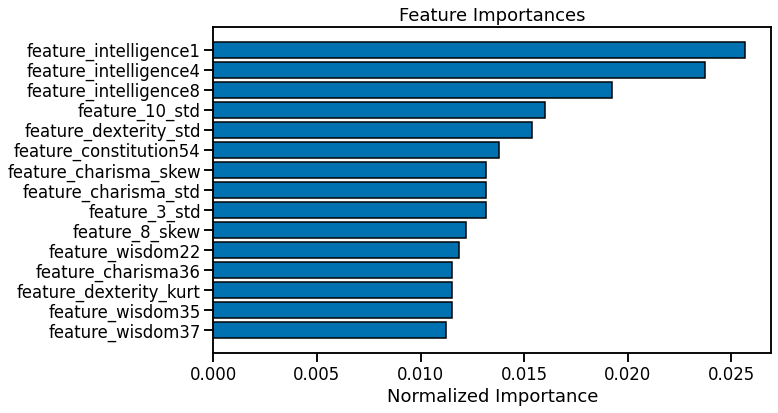

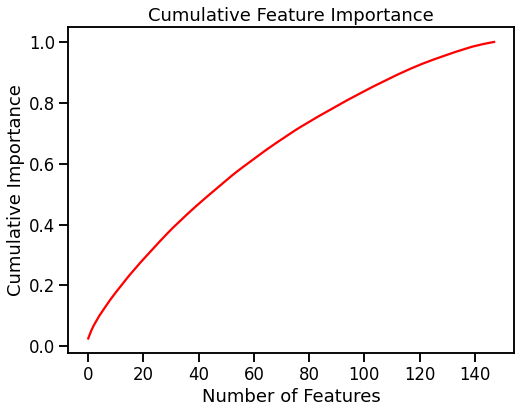

115 features required for 0.90 of cumulative importance


In [53]:
# plot feature importance XGB group 7
norm_feature_importances = plot_feature_importances(feature_importances7)

In [54]:
#about 60 features left
trained = trained.drop(columns = zero_features7)
tested = tested.drop(columns = zero_features7)
valed = valed.drop(columns = zero_features7)
print('LGBM model:')
print('Training selection 7 shape: ', trained.shape)
print('Testing selection 7 shape: ', tested.shape)

LGBM model:
Training selection 7 shape:  (501808, 151)
Testing selection 7 shape:  (1731016, 151)


In [55]:
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))
featured = [f for f in trained.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(featured)))

There are 148 features.
There are 148 features.


In [ ]:
#SPARK version XGBoost
#1.) Transform data to Spark dataset
#trained_spark = spark.createDataFrame(trained)
#tested_spark = spark.createDataFrame(tested)
#valed_spark = spark.createDataFrame(valed)
#val dataset = spark.read.parquet(temp_path)

#modelxgbinst_spark = 

In [59]:
%%time
#TODO improve to multi processor
#Create correlation matrix
corr_matrix = trained.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.98)]

print('There are {} columns with >= 0.98 correlation.'.format(len(to_drop)))
to_drop

There are 0 columns with >= 0.98 correlation.
CPU times: user 35.8 s, sys: 269 ms, total: 36.1 s
Wall time: 35.7 s


[]

In [60]:
#nice one will https://www.kaggle.com/willkoehrsen/featuretools-for-good
# Train 
trained = trained[[x for x in trained if x not in to_drop]]
# Test
tested = tested[[x for x in tested if x not in to_drop]]
# Val
valed = tested[[x for x in tested if x not in to_drop]]

/home/hadoopuser/.local/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


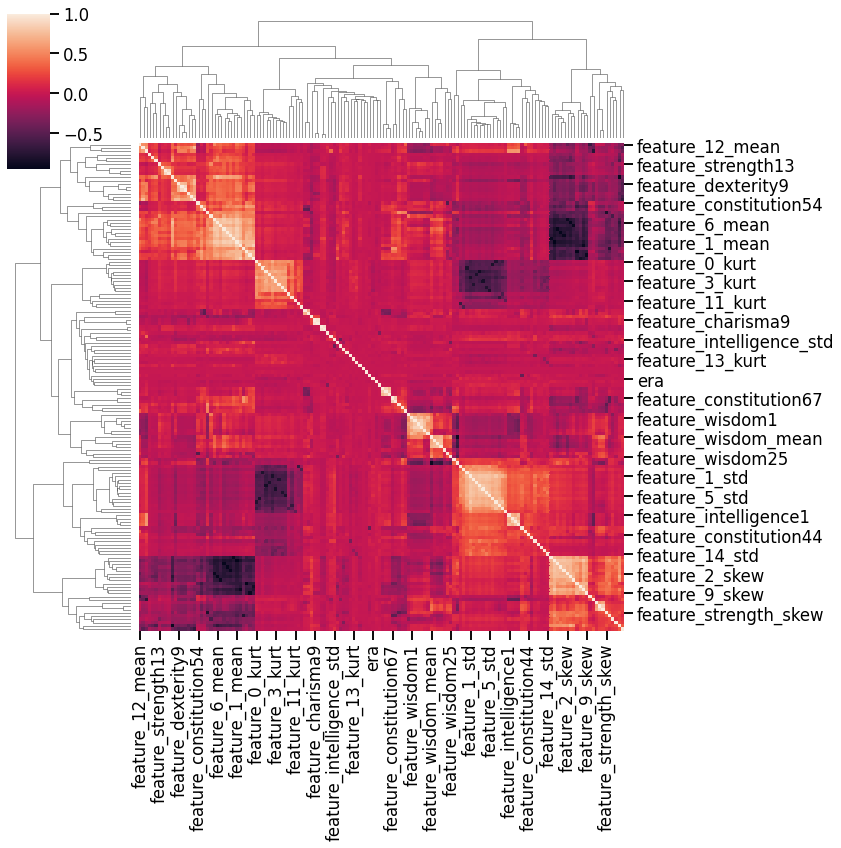

CPU times: user 39.6 s, sys: 2.69 s, total: 42.3 s
Wall time: 37.9 s


In [61]:
%%time
def show_heatmap(df):
    g = sns.clustermap(df.corr(), figsize=(12,12))
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.show()
show_heatmap(trained)

## Feature Selection with feature selection tools on LAG variables 
Era - 1, Era -2, Era -3, Era - 6, Era - 12, Era - 24, Era - 55,

In [62]:
featured = [f for f in trained.columns.values.tolist() if 'feature' in f]
print(len(featured))

148


## NN model preparation Target
target

In [63]:
target = train.columns[train.columns.str.startswith('target')].values.tolist()[0]
print(f'Target name = {target}')
# Model with interaction variables
targeted = trained.columns[trained.columns.str.startswith('target')].values.tolist()[0]
print(f'Targeted name = {targeted}')

Target name = target
Targeted name = target


In [64]:
print(train[target].shape)
print(train.shape)
print(trained[target].shape)
print(trained.shape)

(501808,)
(501808, 151)
(501808,)
(501808, 151)


<AxesSubplot:>

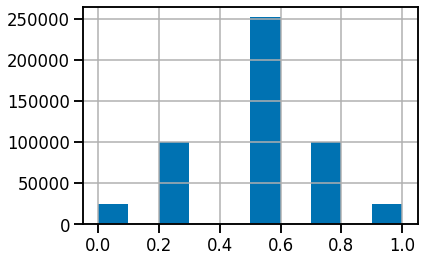

In [65]:
train[target].hist()

In [ ]:
#When having enough memory, no need for reduction
"""
%%time
## Step1: Memory reduction, feature selection removing high correlation   
df = trained
start_mem = df.memory_usage().sum() / 1024**2

print('Memory usage before optimization 1 is: {:.2f} MB'.format(start_mem))
print("The dataframe 1 has {} columns.".format(df.shape[1]))
# Calculate the correlation matrix and take the absolute value 
corr_matrix = df.corr().abs()
# Create a True/False mask and apply it 
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
tri_df = corr_matrix.mask(mask)
# List column names of highly correlated features (r > 0.95) 
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]
# Drop the features in the to_drop list 
df = df.drop(to_drop, axis=1)
training_data = df

end_mem = df.memory_usage().sum() / 1024**2
print('Memory usage after optimization 1 is: {:.2f} MB'.format(end_mem))
feature_names = [f for f in df.columns if f.startswith("feature")]
print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
print("The reduced dataframe 1 has {} columns.".format(df.shape[1]))
## Step2: Memory reduction, precision and data type transformation
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization 2 is: {:.2f} MB'.format(start_mem))
    print("The dataframe 2 has {} columns.".format(df.shape[1]))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    start_mem = end_mem
    print('Memory usage after optimization 2 is: {:.2f} MB'.format(end_mem))
    print("The reduced dataframe 2 has {} columns.".format(df.shape[1]))                
    return df
trained = reduce_mem_usage(trained)
tested = reduce_mem_usage(tested)#.drop(to_drop, axis=1)
valed = reduce_mem_usage(valed)
"""


In [66]:
trained.info()
trained.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 151 entries, id to feature_constitution_kurt
dtypes: float64(88), int64(1), object(1), uint8(61)
memory usage: 373.8+ MB


,era,feature_intelligence1,feature_intelligence3,feature_intelligence4,feature_intelligence6,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_charisma9,...,feature_dexterity_skew,feature_dexterity_kurt,feature_strength_mean,feature_strength_std,feature_strength_skew,feature_strength_kurt,feature_constitution_mean,feature_constitution_std,feature_constitution_skew,feature_constitution_kurt
count,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,...,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000
mean,64.001987,1.999924,1.999916,1.999924,1.999908,1.999924,1.999920,1.999920,1.999924,1.999944,...,0.017350,0.329804,1.999904,1.204340,0.027958,-0.585104,1.999904,1.327010,-0.005408,-0.958930
std,33.332945,1.414384,1.414371,1.414384,1.414349,1.414384,1.408397,1.408397,1.414384,1.413894,...,1.124038,2.786327,0.540414,0.235269,0.537268,0.782917,0.385759,0.183476,0.399379,0.547819
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.741657,-2.363636,0.131579,0.000000,-4.850487,-2.114286,0.649123,0.000000,-4.060563,-1.981460
25%,37.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.516335,-1.062906,1.605263,1.034264,-0.315789,-1.094447,1.736842,1.200741,-0.269237,-1.259070
50%,64.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,-0.348776,2.000000,1.202179,0.026052,-0.729331,2.000000,1.327489,-0.010537,-1.013346
75%,93.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,0.553133,0.501377,2.368421,1.371318,0.371082,-0.257231,2.263158,1.454079,0.256362,-0.732563
max,120.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,3.741657,14.000000,3.842105,2.002310,6.164414,38.000000,3.412281,1.952391,5.120981,36.562941


In [75]:
# Bring 151 selection to GPU machine
trained.to_parquet('trained.parquet')
valed.to_parquet('valed.parquet')


In [76]:
tested.to_parquet('tested.parquet')

In [ ]:
%%time
# When cleaning is needed 
#print(trained.isna().sum())
#print(tested.isna().sum())
#print(valed.isna().sum())
#print(trained.isin([np.inf, -np.inf]))
# Note we use it for the interaction variables as a 0 could arise from substraction
#trained.fillna('')
#tested.fillna('')
#valed.fillna('')
#trained = trained.replace([np.inf, -np.inf], '')
#tested = tested.replace([np.inf, -np.inf], '')
#valed = valed.replace([np.inf, -np.inf], '')

# Modeling
Here we build a simple MLP using tensorflow.

[Example](https://github.com/numerai/example-scripts/blob/master/example_model.py)
Adaboost
[XGBoost](https://jp.docs.numer.ai/numerai-tournament/tournament-overview)



<h4>data prep</h4>

In [67]:
# set seed to reproduce the result
def seed_everything(seed : int) -> NoReturn :    
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(CFG.SEED) 

# Tuning (or not)
Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn. 

Here we use the **BayesianOptimization** tuner.

In [79]:
# my default NN hyperparameters
params = {
    'input_dim': len(featured),#set to featured to use interaction variables, features to use origin
    'input_dropout': 0.0,
    'hidden_layers': 3,
    'hidden_units': 256,
    'hidden_activation': 'relu',
    'lr': 1e-03,
    'dropout': 0.2,
    'batch_size': 128,
    'epochs': 192
}
logger.info('default NN params:')
logger.info(params)

def create_off(params=params):
    """
    baseline model
    """

    # NN model architecture
    n_neuron = params['hidden_units']

    inputs = tf.keras.layers.Input(shape=(params['input_dim'], ))
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dense(n_neuron, activation=params['hidden_activation'])(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(params['dropout'])(x)

    # stack more layers
    for i in np.arange(params['hidden_layers'] - 1):
        x = tf.keras.layers.Dense(n_neuron // (2 * (i+1)), activation=params['hidden_activation'])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(params['dropout'])(x)

    out = tf.keras.layers.Dense(1, activation='linear', name = 'out')(x)
        
    # compile
    model = tf.keras.models.Model(inputs=inputs, outputs=out)
    loss = tf.keras.losses.MeanSquaredError()
    opt = tf.keras.optimizers.Adam(lr=params['lr'])
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    
    return model

def create_model(params=params):
    """
    paper model
    """

    # NN model architecture
    n_neuron = params['hidden_units']

    inputs = tf.keras.layers.Input(shape=(params['input_dim'], ))
    x = tf.keras.layers.Dense(n_neuron, activation=params['hidden_activation'])(x) 
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dropout(params['dropout'])(x)    
    #x = tf.keras.layers.Dense(n_neuron, activation=params['hidden_activation'])(x)
    #x = tf.keras.layers.BatchNormalization()(x)

    # activation
    # stack more layers
    for i in np.arange(params['hidden_layers'] - 1):
        x = tf.keras.layers.Dense(n_neuron // (2 * (i+1)), activation=params['hidden_activation'])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(params['dropout'])(x)

    out = tf.keras.layers.Dense(1, activation='linear', name = 'out')(x)
        
    # compile
    model = tf.keras.models.Model(inputs=inputs, outputs=out)
    loss = tf.keras.losses.MeanSquaredError()
    opt = tf.keras.optimizers.Adam(lr=params['lr'])
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    
    return model

def tuning_model(hp, params=params):
    """
    model tuning with KerasTuner
    """
    
    inputs = tf.keras.layers.Input(shape=(params['input_dim'], ))
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dense(hp.Int('num_units_1', 128, 512, step=128), activation=params['hidden_activation'])(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(hp.Float('dropout_1', 0.0, 0.5, step=0.1, default=0.5))(x)

    for i in range(hp.Int('num_layers', 1, 3)):
        x = tf.keras.layers.Dense(hp.Int(f'num_units_{i+2}', 128, 512, step=128))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(hp.Float(f'dropout_{i+2}', 0.0, 0.5, step=0.1, default=0.5))(x)
        
    # output
    out = tf.keras.layers.Dense(1, activation='linear', name = 'out')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=out)
   
    # compile
    loss = tf.keras.losses.MeanSquaredError()
    opt = tf.keras.optimizers.Adam(lr=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    
    return model

default NN params:
2021-05-30 21:37:06,756 INFO __main__: default NN params:
{'input_dim': 148, 'input_dropout': 0.0, 'hidden_layers': 3, 'hidden_units': 256, 'hidden_activation': 'relu', 'lr': 0.001, 'dropout': 0.2, 'batch_size': 128, 'epochs': 192}
2021-05-30 21:37:06,760 INFO __main__: {'input_dim': 148, 'input_dropout': 0.0, 'hidden_layers': 3, 'hidden_units': 256, 'hidden_activation': 'relu', 'lr': 0.001, 'dropout': 0.2, 'batch_size': 128, 'epochs': 192}


In [69]:
# Data Cleaning

#features = [f for f in train.columns.values.tolist() if 'feature' in f]
# create a dataset for NN based on a task
trained =  trained.replace([np.inf, -np.inf], np.nan)
valed = valed.replace([np.inf, -np.inf], np.nan)
trained = trained.replace(np.nan, 0.5)
valed = valed.replace(np.nan, 0.5)
trained = trained.replace('', 0.5)
valed = valed.replace('', 0.5)
#train_set = {'X': train[features].values, 'y': train[CFG.TARGET].values}
#valid_set = {'X': val[features].values, 'y': val[CFG.TARGET].values}  
trained_set = {'X': trained[featured].values, 'y': trained[CFG.TARGET].values}
valed_set = {'X': valed[featured].values, 'y': valed[CFG.TARGET].values}  

print(trained_set)
print(valed_set)

{'X': array([[ 0.        ,  1.        ,  0.        , ...,  1.10288186,
         0.276155  , -0.47805404],
       [ 0.        ,  0.        ,  1.        , ...,  1.33631866,
        -0.79493795, -0.42093535],
       [ 1.        ,  1.        ,  1.        , ...,  1.32702084,
         0.17982385, -1.16578133],
       ...,
       [ 3.        ,  2.        ,  2.        , ...,  1.50600413,
         0.1364874 , -1.42724074],
       [ 1.        ,  1.        ,  2.        , ...,  1.32877462,
        -0.04813036, -1.30867028],
       [ 3.        ,  2.        ,  3.        , ...,  0.93911036,
         0.4768451 , -0.13629558]]), 'y': array([0.5 , 0.25, 0.25, ..., 0.25, 0.5 , 0.5 ])}
{'X': array([[ 1.        ,  2.        ,  2.        , ...,  1.45479949,
         0.08854274, -1.51661377],
       [ 3.        ,  3.        ,  4.        , ...,  1.42602075,
         0.42483664, -1.23004261],
       [ 4.        ,  0.        ,  4.        , ...,  1.48165829,
         0.26885292, -1.26724565],
       ...,
       

In [80]:
%%time
# Set to model met interaction variables (trained_set and valed_set from above used)
#about 360 min with 108 variables on 2x Xeon e5-v2692 v2 and 120gb ddr3 ond dl360p gen8 server
if CFG.TUNING:
    # define a custom tuner to tune the batch size
    class MyTuner(kt.tuners.BayesianOptimization):
      def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 128, 8192, step=128)
#         kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

    # instantiate KerasTuner
    model_ft = lambda hp: tuning_model(hp, params)
    tuner = MyTuner(
        hypermodel=model_ft,
        objective=kt.Objective('val_loss', direction='min'),
        num_initial_points=4,
        max_trials=20,
        overwrite=True)
    
    # perform tuning
    tuner.search(trained_set['X'], trained_set['y'], 
                 epochs = 2, validation_data = (valed_set['X'], valed_set['y']))

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
    
    # Build the model with the optimal hyperparameters and train it on the data
    model = tuner.hypermodel.build(best_hps)
    
    # disp best params
    logger.info('Best hyperparameters:')
    logger.info(best_hps.values)
else:
    # baseline (no tuning)
    model = create_model(params)
#23 minutes on server per 30 trials

Trial 20 Complete [00h 02m 15s]
val_loss: 0.004410131834447384

Best val_loss So Far: 0.004001830704510212
Total elapsed time: 00h 42m 01s
INFO:tensorflow:Oracle triggered exit


2021-05-30 22:19:17,879 INFO tensorflow: Oracle triggered exit
Best hyperparameters:
2021-05-30 22:19:18,381 INFO __main__: Best hyperparameters:
{'num_units_1': 128, 'dropout_1': 0.5, 'num_layers': 1, 'num_units_2': 128, 'dropout_2': 0.5, 'learning_rate': 0.01, 'batch_size': 8192, 'num_units_3': 128, 'dropout_3': 0.5, 'num_units_4': 512, 'dropout_4': 0.5}
2021-05-30 22:19:18,383 INFO __main__: {'num_units_1': 128, 'dropout_1': 0.5, 'num_layers': 1, 'num_units_2': 128, 'dropout_2': 0.5, 'learning_rate': 0.01, 'batch_size': 8192, 'num_units_3': 128, 'dropout_3': 0.5, 'num_units_4': 512, 'dropout_4': 0.5}


CPU times: user 3h 4min 36s, sys: 23min 45s, total: 3h 28min 22s
Wall time: 42min 2s


Round 266:
16 trials
val_loss: 0.0042099845595657825
Best val_loss So Far: 0.00406567333266139
params = {
    'input_dim': len(featured),#set to featured to use interaction variables, features to use origin
    'input_dropout': 0.0,
    'hidden_layers': 3,
    'hidden_units': 166,#256
    'hidden_activation': 'relu',
    'lr': 1e-03,
    'dropout': 0.2,
    'batch_size': 128,
    'epochs': 5#192
Round 256:
val_loss: 0.027023138478398323
Best val_loss So Far: 0.023983798921108246



In [81]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 148)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 148)               592       
_________________________________________________________________
dense (Dense)                (None, 128)               19072     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512   

# Fit with the best model
Let's use the model with the best hyperparameters (if tuned). 

Here I use **Early Stopping** such that the model does not overfit. 

As a learning rate scheduler, I use **ReduceLROnPlateau**.

I do not submit the model prediction in this notebook, but to make the submission process a bit easier, I save the entire model!

In [82]:
%%time

# callbacks
es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, mode='min')
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='mybestweight.hdf5', save_weights_only=True, 
#                                                                verbose=0, monitor='val_loss', save_best_only=True)
nn_callbacks = [es, lr_scheduler, ]

# fit for interaction variables adjust train_set -> trained_set valid_set -> valed set
history = model.fit(trained_set['X'], trained_set['y'], callbacks=nn_callbacks, 
                    verbose=2, epochs=params['epochs'], batch_size=best_hps.values['batch_size'], 
                    validation_data=(valed_set['X'], valed_set['y'])) 

# you can load the model for inference
# model = tf.keras.models.load_model(CFG.OUTPUT_DIR + 'saved_model/my_model')

Epoch 1/192
62/62 - 7s - loss: 0.6652 - mse: 0.6652 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 2/192
62/62 - 3s - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 3/192
62/62 - 3s - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 4/192
62/62 - 3s - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 5/192
62/62 - 3s - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/192
62/62 - 3s - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/192
62/62 - 3s - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 8/192
62/62 - 3s - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 9/192
62/62 - 3s - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 10/192
62/62 - 3s - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0040 - val_mse: 0.0040

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/192
62/62 - 3s - lo

In [83]:
# save the entire model
model.save(CFG.OUTPUT_DIR + 'my_model264.h5')
logger.info('Entire model saved!')

Entire model saved!
2021-05-30 22:19:53,241 INFO __main__: Entire model saved!


2021-05-30 22:19:53,291 WARNING matplotlib.font_manager: findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
2021-05-30 22:19:53,309 WARNING matplotlib.font_manager: findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


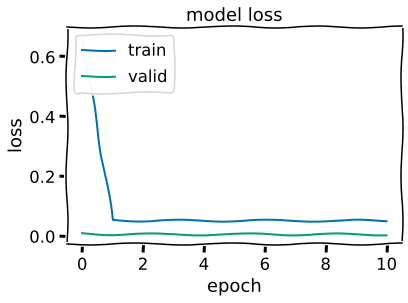

In [84]:
# summarize history for loss
with plt.xkcd(): # just for fun
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

* # Validation Prediction

In [85]:
# prediction for valid
pred = model.predict(valed_set['X']).ravel()

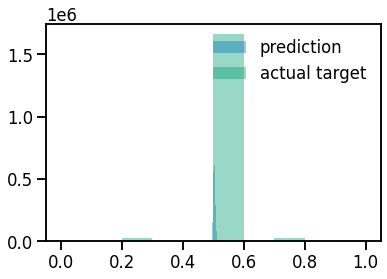

In [86]:
plt.hist(pred, alpha=0.4, label='prediction')
plt.hist(valed_set['y'], alpha=0.4, label='actual target')
plt.legend(frameon=False)

In [87]:
# naming conventions
PREDICTION_NAME = 'prediction'
TARGET_NAME = target
# EXAMPLE_PRED = 'example_prediction'

# ---------------------------
# Functions
# ---------------------------
def valid4score(valid : pd.DataFrame, pred : np.ndarray, load_example: bool=True, save : bool=False) -> pd.DataFrame:
    """
    Generate new valid pandas dataframe for computing scores
    
    :INPUT:
    - valid : pd.DataFrame extracted from tournament data (data_type='validation')
    
    """
    valid_df = valid.copy()
    valid_df['prediction'] = pd.Series(pred).rank(pct=True, method="first")
    valid_df.rename(columns={target: 'target'}, inplace=True)
    
    if load_example:
        valid_df[EXAMPLE_PRED] = pd.read_csv(EXP_DIR + 'valid_df.csv')['prediction'].values
    
    if save==True:
        valid_df.to_csv(OUTPUT_DIR + 'valid_df.csv', index=False)
        print('Validation dataframe saved!')
    
    return valid_df

def compute_corr(valid_df : pd.DataFrame):
    """
    Compute rank correlation
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    
    """
    
    return np.corrcoef(valid_df["target"], valid_df['prediction'])[0, 1]

def compute_max_drawdown(validation_correlations : pd.Series):
    """
    Compute max drawdown
    
    :INPUT:
    - validation_correaltions : pd.Series
    """
    
    rolling_max = (validation_correlations + 1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (validation_correlations + 1).cumprod()
    max_drawdown = -(rolling_max - daily_value).max()
    
    return max_drawdown

def compute_val_corr(valid_df : pd.DataFrame):
    """
    Compute rank correlation for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    
    # all validation
    correlation = compute_corr(valid_df)
    print("rank corr = {:.4f}".format(correlation))
    return correlation
    
def compute_val_sharpe(valid_df : pd.DataFrame):
    """
    Compute sharpe ratio for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    # all validation
    d = valid_df.groupby('era')[['target', 'prediction']].corr().iloc[0::2,-1].reset_index()
    me = d['prediction'].mean()
    sd = d['prediction'].std()
    max_drawdown = compute_max_drawdown(d['prediction'])
    print('sharpe ratio = {:.4f}, corr mean = {:.4f}, corr std = {:.4f}, max drawdown = {:.4f}'.format(me / sd, me, sd, max_drawdown))
    
    return me / sd, me, sd, max_drawdown
    
def feature_exposures(valid_df : pd.DataFrame):
    """
    Compute feature exposure
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    feature_names = [f for f in valid_df.columns
                     if f.startswith("feature")]
    exposures = []
    for f in feature_names:
        fe = spearmanr(valid_df['prediction'], valid_df[f])[0]
        exposures.append(fe)
    return np.array(exposures)

def max_feature_exposure(fe : np.ndarray):
    return np.max(np.abs(fe))

def feature_exposure(fe : np.ndarray):
    return np.sqrt(np.mean(np.square(fe)))

def compute_val_feature_exposure(valid_df : pd.DataFrame):
    """
    Compute feature exposure for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    # all validation
    fe = feature_exposures(valid_df)
    fe1, fe2 = feature_exposure(fe), max_feature_exposure(fe)
    print('feature exposure = {:.4f}, max feature exposure = {:.4f}'.format(fe1, fe2))
     
    return fe1, fe2

# to neutralize a column in a df by many other columns
def neutralize(df, columns, by, proportion=1.0):
    scores = df.loc[:, columns]
    exposures = df[by].values

    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack(
        (exposures,
         np.asarray(np.mean(scores)) * np.ones(len(exposures)).reshape(-1, 1)))

    scores = scores - proportion * exposures.dot(
        np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()


# to neutralize any series by any other series
def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def get_feature_neutral_mean(df):
    feature_cols = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(df, [PREDICTION_NAME],
                                          feature_cols)[PREDICTION_NAME]
    scores = df.groupby("era").apply(
        lambda x: np.corrcoef(x["neutral_sub"].rank(pct=True, method="first"), x[TARGET_NAME])).mean()
    return np.mean(scores)

def compute_val_mmc(valid_df : pd.DataFrame):    
    # MMC over validation
    mmc_scores = []
    corr_scores = []
    for _, x in valid_df.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[PREDICTION_NAME])),
                                   pd.Series(unif(x[EXAMPLE_PRED])))
        mmc_scores.append(np.cov(series, x[TARGET_NAME])[0, 1] / (0.29 ** 2))
        corr_scores.append(np.corrcoef(unif(x[PREDICTION_NAME]).rank(pct=True, method="first"), x[TARGET_NAME]))

    val_mmc_mean = np.mean(mmc_scores)
    val_mmc_std = np.std(mmc_scores)
    val_mmc_sharpe = val_mmc_mean / val_mmc_std
    corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
    corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)
    corr_plus_mmc_mean = np.mean(corr_plus_mmcs)

    print("MMC Mean = {:.6f}, MMC Std = {:.6f}, CORR+MMC Sharpe = {:.4f}".format(val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe))

    # Check correlation with example predictions
    corr_with_example_preds = np.corrcoef(valid_df[EXAMPLE_PRED].rank(pct=True, method="first"),
                                          valid_df[PREDICTION_NAME].rank(pct=True, method="first"))[0, 1]
    print("Corr with example preds: {:.4f}".format(corr_with_example_preds))
    
    return val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe, corr_with_example_preds
    
def score_summary(valid_df : pd.DataFrame):
    score_df = {}
    
    try:
        score_df['correlation'] = compute_val_corr(valid_df)
    except:
        print('ERR: computing correlation')
    try:
        score_df['corr_sharpe'], score_df['corr_mean'], score_df['corr_std'], score_df['max_drawdown'] = compute_val_sharpe(valid_df)
    except:
        print('ERR: computing sharpe')
    try:
        score_df['feature_exposure'], score_df['max_feature_exposure'] = compute_val_feature_exposure(valid_df)
    except:
        print('ERR: computing feature exposure')
    try:
        score_df['mmc_mean'], score_df['mmc_std'], score_df['corr_mmc_sharpe'], score_df['corr_with_example_xgb'] = compute_val_mmc(valid_df)
    except:
        print('ERR: computing MMC')
    
    return pd.DataFrame.from_dict(score_df, orient='index')

In [88]:
#valed = tested[tested["data_type"] == "validation"].reset_index(drop = True)
# validation split
valed.loc[valed["era"] > 180, "valid2"] = True 
valed.loc[valed["era"] <= 180, "valid2"] = False 

In [89]:
#Results of NN
valid_df = valid4score(valed, pred, load_example=False, save=False)

# scores
score_df = pd.DataFrame()
print('------------------')
print('ALL:')
print('------------------')
all_ = score_summary(valid_df).rename(columns={0: 'all'})

print('------------------')
print('VALID 1:')
print('------------------')
val1_ = score_summary(valid_df.query('era < 150')).rename(columns={0: 'val1'})

print('------------------')
print('VALID 2:')
print('------------------')
val2_ = score_summary(valid_df.query('era > 150')).rename(columns={0: 'val2'})
#add validation split back from graveyard

------------------
ALL:
------------------
rank corr = 0.0015
sharpe ratio = 0.2445, corr mean = 0.0057, corr std = 0.0234, max drawdown = -0.0856
feature exposure = 0.1929, max feature exposure = 0.5173
ERR: computing MMC
------------------
VALID 1:
------------------
rank corr = 0.0161
sharpe ratio = 0.6970, corr mean = 0.0161, corr std = 0.0231, max drawdown = -0.0241
feature exposure = 0.1956, max feature exposure = 0.5208
ERR: computing MMC
------------------
VALID 2:
------------------
rank corr = -0.0005
sharpe ratio = -0.0984, corr mean = -0.0021, corr std = 0.0211, max drawdown = -0.0709
feature exposure = 0.1928, max feature exposure = 0.5172
ERR: computing MMC


In [90]:
# scores
score_df = pd.concat([all_, val1_, val2_], axis=1)
score_df.style.background_gradient(cmap='viridis', axis=0)

,all,val1,val2
correlation,0.001528,0.016135,-0.000472
corr_sharpe,0.244456,0.697038,-0.098397
corr_mean,0.005728,0.016131,-0.002074
corr_std,0.023433,0.023142,0.021074
max_drawdown,-0.085617,-0.024084,-0.070860
feature_exposure,0.192876,0.195626,0.192800
max_feature_exposure,0.517305,0.520759,0.517185


[[0.49509746]
 [0.50063044]
 [0.50680727]
 [0.5052201 ]
 [0.5044276 ]]
                 id  prediction
0  n0003aa52cab36c2    0.007444
1  n000920ed083903f    0.314304
2  n0038e640522c4a6    0.905079
3  n004ac94a87dc54b    0.814453
4  n0052fe97ea0c05f    0.750395


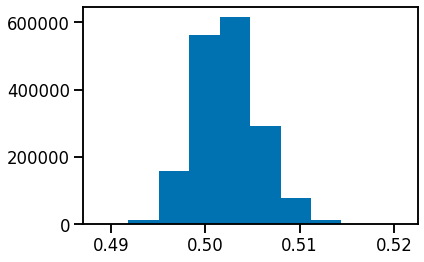

In [91]:
OUTPUT_DIR = str(current_ds)
# prediction
pred = model.predict(tested[featured].fillna(0.5))
plt.hist(pred);
predictions_df = test["id"].to_frame()

predictions_df[PREDICTION_NAME] = pred
print(pred[0:5])
# to rank
predictions_df[PREDICTION_NAME] = predictions_df[PREDICTION_NAME].rank(pct=True, method="first")
predictions_df = predictions_df.fillna(0.5)
print(predictions_df[0:5])


In [92]:
predictions_df.to_csv(OUTPUT_DIR + 'predictions_MLP_develusem.csv',index=False)

In [93]:

#predictions_df.to_csv(pathlib.Path(OUTPUT_DIR + f"_predictions_MLP_develusem.csv"), index=False)
    

In [94]:
print(len(pred))

1731016


XGBoostもLightGBM GBDT (Gradient Boosting Decision Tree)

[](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1)

In [95]:
%%time
# This is a hugh winner, scored above 0.10
# create a model and fit（LGB）
params = {
            'n_estimators': 4000,#2000
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'max_depth': 6,#5
            'learning_rate': 0.01,#0.01
            'feature_fraction': 0.1,
            'seed': 42
            }    
model = lgb.LGBMRegressor(**params)
model.fit(trained[featured], trained['target'])

CPU times: user 3min 48s, sys: 192 ms, total: 3min 48s
Wall time: 3min 45s


LGBMRegressor(feature_fraction=0.1, learning_rate=0.01, max_depth=6,
              n_estimators=4000, objective='regression', seed=42)

In [108]:
# save model（）
joblib.dump(model, 'my_lightgbm266.joblib') 
print('model saved!')

model saved!


# Feature importance


In [97]:
pd.DataFrame(model.feature_importances_, index=featured, columns=['importance']).sort_values(by='importance', ascending=False).style.background_gradient(cmap='viridis')

,importance
feature_constitution_mean,2426
feature_strength_mean,1522
feature_4_std,1444
feature_charisma_mean,1440
feature_1_mean,1435
feature_10_std,1425
feature_constitution_skew,1422
feature_wisdom_kurt,1421
feature_wisdom_mean,1420
feature_dexterity_std,1410


# Validation Score
Validation(target rank correlation)Numerai[Github](https://github.com/numerai/example-scripts/blob/master/example_model.py)

MMC（meta model correlation） (rank correlation)**correlation sharpe**

- rank correlation (NumeraiCORR)
- sharpe ratio（CORR）
- max drawdown (CORR。0)
- feature exposure ()

Numerai validation


This is what we care about! Here we compute Numerai-related scores except for MMC (which we cannot compute as we don't have a meta-model prediction).

Note that we split the validation set into the two parts and compute scores on the corresponding eras. This is because the first half validation eras are easy to predict, whereas the last half are hard. It is better to see that our model performs well on the both periods.

In [98]:
%%time
# prediction for valid periods   
predLGB = model.predict(valed[featured].fillna(0.5))

CPU times: user 11min 4s, sys: 2.35 s, total: 11min 6s
Wall time: 10min 58s


In [99]:
"""
# scores
valid_df = valid4score(valed, pred, load_example=False, save=False)

score_df = pd.DataFrame()
print('------------------')
print('ALL:')
print('------------------')
all_ = score_summary(valid_df).rename(columns={0: 'all'})

print('------------------')
print('VALID 1:')
print('------------------')
val1_ = score_summary(valid_df.query('era < 150')).rename(columns={0: 'val1'})

print('------------------')
print('VALID 2:')
print('------------------')
val2_ = score_summary(valid_df.query('era > 150')).rename(columns={0: 'val2'})
"""

"\n# scores\nvalid_df = valid4score(valed, pred, load_example=False, save=False)\n\nscore_df = pd.DataFrame()\nprint('------------------')\nprint('ALL:')\nprint('------------------')\nall_ = score_summary(valid_df).rename(columns={0: 'all'})\n\nprint('------------------')\nprint('VALID 1:')\nprint('------------------')\nval1_ = score_summary(valid_df.query('era < 150')).rename(columns={0: 'val1'})\n\nprint('------------------')\nprint('VALID 2:')\nprint('------------------')\nval2_ = score_summary(valid_df.query('era > 150')).rename(columns={0: 'val2'})\n"

In [100]:
# scores
#score_df = pd.concat([all_, val1_, val2_], axis=1)
#score_df.style.background_gradient(cmap='viridis', axis=0)

# Submission
[Numerai tournament](https://numer.ai/tournament)API ID Rank correlation rank

(array([1.900000e+01, 8.600000e+01, 5.670000e+02, 6.587000e+03,
        2.841220e+05, 1.354115e+06, 8.286300e+04, 2.479000e+03,
        1.640000e+02, 1.400000e+01]),
 array([0.33000223, 0.36193595, 0.39386966, 0.42580337, 0.45773709,
        0.4896708 , 0.52160451, 0.55353822, 0.58547194, 0.61740565,
        0.64933936]),
 <BarContainer object of 10 artists>)

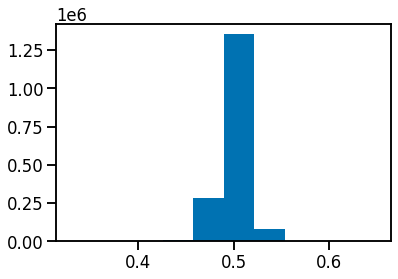

In [101]:
# prediction
pred = model.predict(tested[featured].fillna(0.5))
plt.hist(pred)

In [102]:
predictions_df = test["id"].to_frame()
predictions_df[PREDICTION_NAME] = pred
print(pred[0:5])
# to rank
predictions_df[PREDICTION_NAME] = predictions_df[PREDICTION_NAME].rank(pct=True, method="first")
predictions_df.to_csv(pathlib.Path(OUTPUT_DIR + f"predictions_lgb_develusex.csv"), index=False)

[0.48973913 0.49544317 0.52175922 0.51056563 0.4998682 ]


In [103]:
print(tested.index)

RangeIndex(start=0, stop=1731016, step=1)


In [104]:
print(test["id"])


0          n0003aa52cab36c2
1          n000920ed083903f
2          n0038e640522c4a6
3          n004ac94a87dc54b
4          n0052fe97ea0c05f
                 ...       
1731011    nffbe5152c321f92
1731012    nffc011b4baa54c3
1731013    nffc12b2a846ab4e
1731014    nffc3c5ab0235de0
1731015    nffe714f0da4d819
Name: id, Length: 1731016, dtype: object


OSError: [Errno 28] No space left on device

In [ ]:
#XGBOOST with boosting

In [ ]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def era_boost_train(X, y, era_col, proportion=0.5, trees_per_step=10, num_iters=200, one_shot=False, tree_method='gpu_hist', test_model=None, note=None):
    print(f"\n#### Era boost train with proportion {proportion:0.3f} ####\n")
    if note is not None:
        print(note)
    if one_shot:
        trees_per_step = trees_per_step * num_iters
        num_iters=1

    if test_model is None:
        print(f"Train {num_iters} iterations")
        print(f"Train {trees_per_step} rounds per iteration")
    else:
        print("Testing model performance")
    features = X.columns
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    for i in range(num_iters):
        print(f"\nIteration {i+1}:\n")
        if test_model is None:
            if i==0:
                model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=trees_per_step, n_jobs=-1, colsample_bytree=0.1, tree_method=tree_method)
                model.fit(X, y)
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        else:
            model = test_model
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        plt.savefig(outdir+f"fig_{i}.png")
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
    return model
#https://forum.numer.ai/t/era-boosted-models/189/4
# Needs GPU
# boost_model = era_boost_train(trained[featured], trained["target"], era_col=trained["era"], proportion=0.5, trees_per_step=10, num_iters=20)

# 

- [KagglerNumerai](https://zenn.dev/katsu1110/articles/bb2b5cba9b04c9e30bfe)
- [Numerai Github](https://github.com/numerai)

In [ ]:
#error check if * notebook is running

In [110]:
# TPOT
import os
from datetime import datetime
# Import libraries
########################################################
######## IMPORTING NECESSARY MODULES AND MODELS ########
########################################################
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import explained_variance_score, median_absolute_error, r2_score, mean_squared_error #To evaluate our model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
#import category_encoders as ce
import timeit
#import category_encoders
from math import sqrt
from scipy import stats
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor


from sklearn.metrics import make_scorer
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from tpot import TPOTRegressor
from tpot.export_utils import expr_to_tree, generate_export_pipeline_code
def convert_to_float16(df):
    dtypes = {}
    for col_name in df.columns.tolist():
        if col_name.startswith(('feature', 'target')):
            dtypes[col_name] = np.float16
    return df.set_index('id').astype(dtypes)
from tpot.builtins import StackingEstimator
from sklearn.linear_model import RidgeCV, LassoLarsCV, ElasticNetCV
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import FeatureAgglomeration
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,  cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive
from numpy import nan
from tpot.builtins import ZeroCount
from numpy import nan
X_train = trained[featured].to_numpy()
y_train = trained[f'target']

X_test = tested[featured].to_numpy()
y_test = tested[f'target']


pipeline_1 = Pipeline(steps=[('zerocount-1', ZeroCount()), ('zerocount-2', ZeroCount()),
                ('xgbregressor',
                 XGBRegressor(alpha=1, base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=0,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=4, min_child_weight=9,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=1, num_parallel_tree=1,
                              random_state=55, reg_alpha=1, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.8,
                              tree_method='hist', validate_parameters=1,
                              verbosity=0))])
pipeline_2 = make_pipeline(
    SelectPercentile(score_func=f_regression, percentile=89),
    StackingEstimator(estimator=DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=15)),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.75, tol=0.001)),
    LinearSVR(C=0.001, dual=True, epsilon=0.01, loss="epsilon_insensitive", tol=1e-05)
)
pipeline_3 = make_pipeline(
XGBClassifier(FeatureAgglomeration(input_matrix, affinity=euclidean, linkage=ward), learning_rate=1.0, max_depth=1, 
              min_child_weight=10, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0))

pipeline_1.fit(X_train, y_train)
results1 = pipeline_1.predict(X_test)
pipeline_2.fit(X_train, y_train)
results2 = pipeline_2.predict(X_test)
pipeline_3.fit(X_train, y_train)
results3 = pipeline_3.predict(X_test)

In [115]:
%%time
# Make a custom metric function for TPOT
# Root mean squared logarithmic error is how Kaggle scores this task
# Can't use custom scorer with n_jobs > 1.  Known issue.

def custom_rmsle(y_true, y_pred):
     return np.sqrt(np.mean((np.log(1 + y_pred) - np.log(1 + y_true))**2))

# Make a custom scorer from the custom metric function
rmsle = make_scorer(custom_rmsle, greater_is_better=False)

# Number of pipelines is very small below so that we can quickly commit on Kaggle
# parameters http://epistasislab.github.io/tpot/using/

# instantiate tpot 
tpot = TPOTRegressor(verbosity=2,  
                    random_state=55, 
                    scoring=rmsle,
                    periodic_checkpoint_folder="intermediate_results",
                    n_jobs=-1, 
                    warm_start = True,
                    generations=30, 
                    population_size=29,
                    early_stop=7,
                    config_dict='TPOT NN')
times = []
scores = []
winning_pipes = []

# run 2 iterations
for x in range(1):
    start_time = timeit.default_timer()
    tpot.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    times.append(elapsed)
    winning_pipes.append(tpot.fitted_pipeline_)
    scores.append(tpot.score(X_test, y_test))
    tpot.export('tpot_ames.py')

# output results
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)
# export the best model
tpot.export('tpot_develuse_best_model.py')


./numerai_dataset_266.zip: 406MB [30:58:50, 1.52MB/s]


Generation 1 - Current best internal CV score: -0.15393210533567667


./numerai_dataset_266.zip: 406MB [31:04:39, 1.52MB/s]


Generation 2 - Current best internal CV score: -0.15393210533567667


2021-05-31 08:02:31,292 WARNING stopit: Code block execution exceeded 10 seconds timeout
Traceback (most recent call last):
  File "/home/hadoopuser/.local/lib/python3.8/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/home/hadoopuser/.local/lib/python3.8/site-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/home/hadoopuser/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/hadoopuser/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 436, in inner_f
    return f(**kwargs)
  File "/home/hadoopuser/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1176, in fit
    self._Booster = train(
  File "/home/hadoopuser/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 189, in train
    bst = _train_internal(params, dtrain,
  File "/home/hadoopuser/anaconda3/lib/python3.8/sit


Generation 3 - Current best internal CV score: -0.15393210533567667


./numerai_dataset_266.zip: 406MB [32:03:44, 1.52MB/s]


Generation 4 - Current best internal CV score: -0.15393210533567667


./numerai_dataset_266.zip: 406MB [33:35:05, 1.52MB/s]


Generation 5 - Current best internal CV score: -0.15393210533567667


./numerai_dataset_266.zip: 406MB [33:53:24, 1.52MB/s]


Generation 6 - Current best internal CV score: -0.15393210533567667


./numerai_dataset_266.zip: 406MB [33:59:26, 1.52MB/s]


Generation 7 - Current best internal CV score: -0.15393210533567667


./numerai_dataset_266.zip: 406MB [34:05:30, 1.52MB/s]


Generation 8 - Current best internal CV score: -0.15393210533567667

The optimized pipeline was not improved after evaluating 7 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(FeatureAgglomeration(input_matrix, affinity=euclidean, linkage=ward), learning_rate=1.0, max_depth=1, min_child_weight=10, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)

Best pipeline: XGBClassifier(FeatureAgglomeration(input_matrix, affinity=euclidean, linkage=ward), learning_rate=1.0, max_depth=1, min_child_weight=10, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)

Best pipeline: XGBClassifier(FeatureAgglomeration(input_matrix, affinity=euclidean, linkage=ward), learning_rate=1.0, max_depth=1, min_child_weight=10, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)

Best pipeline: XGBClassifier(FeatureAgglomeration(input_matrix, affinity=euclidean, linkage=ward), learning_rate=1.0, max_dep

ValueError: Unknown label type: 'continuous'

In [114]:
TOURNAMENT_NAME = 'Numer'
print(results1[1:5])
print(results2[1:5])
#print(results3[1:5])
#print(results4[1:5])
df_pl_1 = pd.DataFrame(results1)
df_pl_2 = pd.DataFrame(results2)
#df_pl_3 = pd.DataFrame(results3)
#df_pl_4 = pd.DataFrame(results3)
#tournament_data = read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")

test[PREDICTION_NAME] = df_pl_1.values.reshape(-1, 1)
test[PREDICTION_NAME].to_csv(f"{TOURNAMENT_NAME}_{current_ds}_submission_pl_1.csv")

test[PREDICTION_NAME] = df_pl_2.values.reshape(-1, 1)
test[PREDICTION_NAME].to_csv(f"{TOURNAMENT_NAME}_{current_ds}_submission_pl_2.csv")

#tournament_data[PREDICTION_NAME] = df_pl_3.values.reshape(-1, 1)
#tournament_data[PREDICTION_NAME].to_csv(f"{TOURNAMENT_NAME}_{current_ds}_submission_pl_3.csv")

#tournament_data[PREDICTION_NAME] = df_pl_4.values.reshape(-1, 1)
#tournament_data[PREDICTION_NAME].to_csv(f"{TOURNAMENT_NAME}_{current_ds}_submission_pl_4.csv")

[0.4963926  0.50801176 0.49943662 0.49989018]
[0.49493432 0.51862446 0.49801733 0.49731408]
